# Attempt to do UK coins feature extraction by Transfer Learning from Inception v3 model by Google

# Clear -ONLY FOR RESETTING ENVIRONMENT
Keras backend to try new model (Only do this if you want to change model parameters)

In [13]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Clear the current TensorFlow graph
K.clear_session(free_memory=True)


# Reinitialize your model from scratch
model = None  # Explicitly set to None
UKmodel = None
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

: 

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

2025-03-31 18:34:51.904519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743442491.920232  228188 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743442491.924977  228188 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743442491.937205  228188 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743442491.937218  228188 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743442491.937220  228188 computation_placer.cc:177] computation placer alr

Download Weights

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-03-31 16:58:59--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.200.27, 172.217.169.91, 142.250.179.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.200.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  14.6MB/s    in 8.2s    

2025-03-31 16:59:09 (10.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



# Import InceptionV3

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction.

Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

In [4]:
for layer in pre_trained_model.layers:
  layer.trainable = False

The layer we will use for feature extraction in Inception v3 is called `mixed7`. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from `mixed7`:

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output.shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


Now Let's stick a fully connected layer to that:

In [6]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers 
from keras.losses import CategoricalCrossentropy

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001))(x)  # Added L2 regularization

# Add a dropout rate of 0.2
x = layers.Dropout(0.8)(x)
# Add a final Relu function for non-binary classification
x = layers.Dense(8, activation='softmax')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1),   # 'categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])

Summary of the model:

In [7]:
# keeping output in a small scrollable window as model is huge 
from IPython.display import HTML

def get_model_summary(model):
    # Redirect model.summary() to a string
    import io
    summary_string = io.StringIO()
    model.summary(print_fn=lambda x: summary_string.write(x + '\n'))
    
    # Create scrollable container with monospace font for proper formatting
    return HTML(f'''
    <div style="max-height:300px; overflow:auto; font-family:monospace; white-space:pre;">
    {summary_string.getvalue()}
    </div>
    ''')

# Usage:
get_model_summary(model)

The model is designed and compiled

# Load our UK coins images

In [8]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# !wget https://edshare.gcu.ac.uk/id/document/61325 \
#       -O /content/UK_coins_ClassSplit.zip

# local_zip = './content/UK_coins_ClassSplit.rar'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('./')
# zip_ref.close()
UK_base_dir = './UK_coins_ClassSplit'

Take a look at coins to confirm fully loaded:

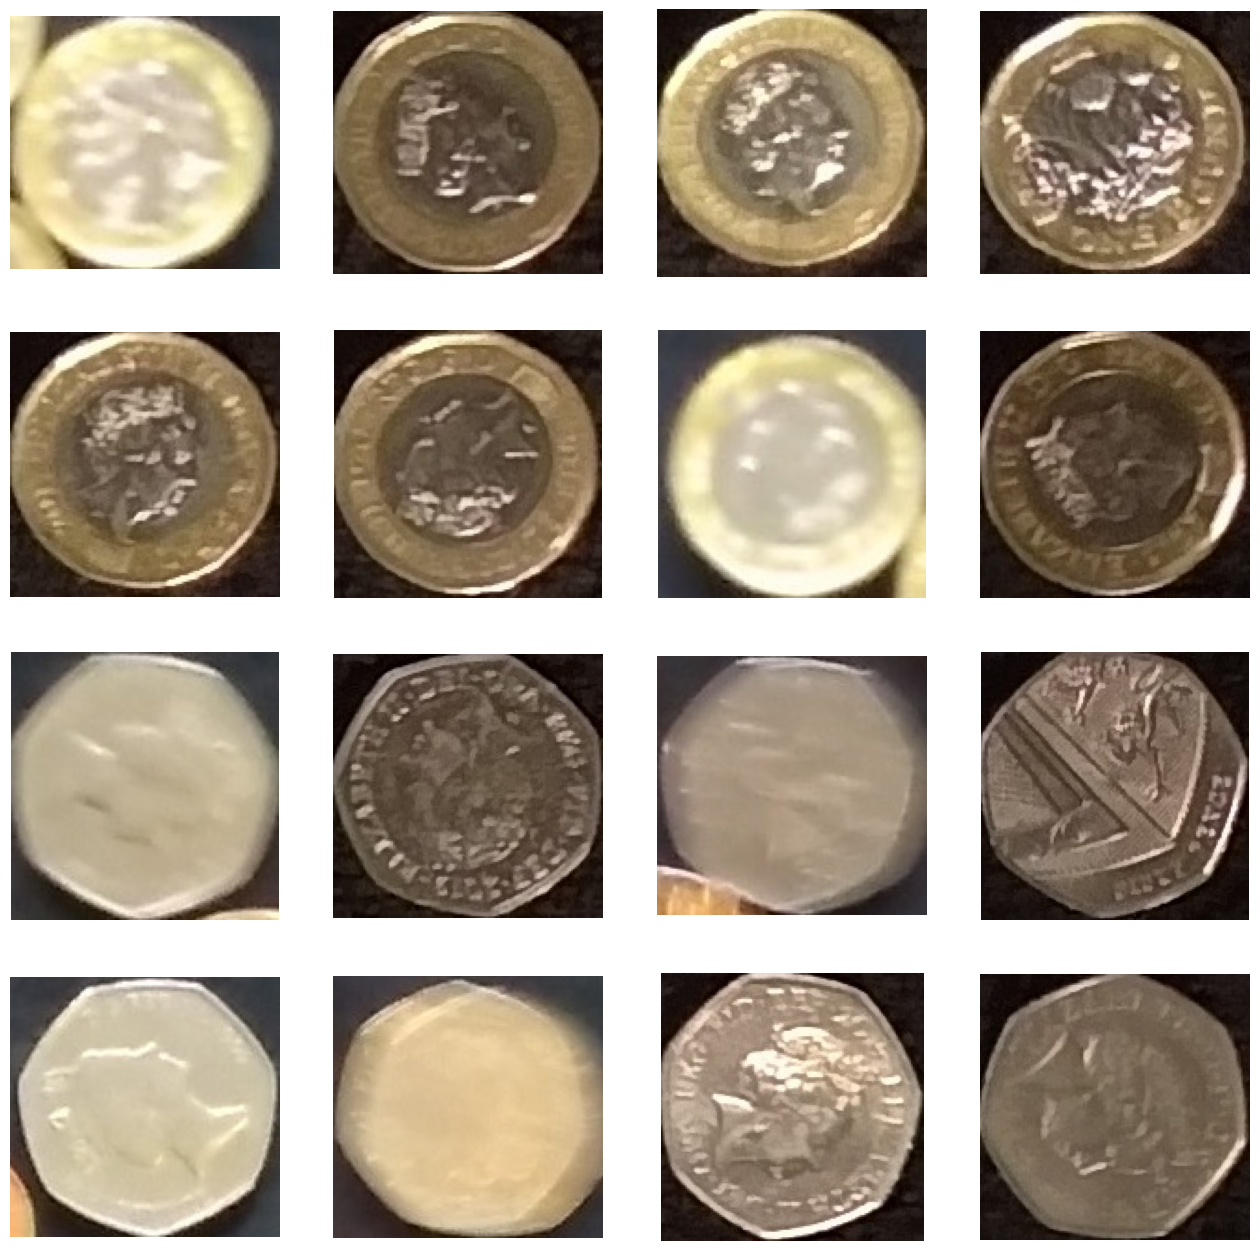

In [9]:
#@title Show some coins
UK_100_dir = os.path.join(UK_base_dir, '100')
UK_050_dir = os.path.join(UK_base_dir, '050')
nrows = 4
ncols = 4
train_100_fnames = os.listdir(UK_100_dir)
train_050_fnames = os.listdir(UK_050_dir)
pic_index = 0 # Index for iterating over images
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 8
next_100_pix = [os.path.join(UK_100_dir, fname)
                for fname in train_100_fnames[pic_index-8:pic_index]]
next_050_pix = [os.path.join(UK_050_dir, fname)
                for fname in train_050_fnames[pic_index-8:pic_index]]
for i, img_path in enumerate(next_100_pix+next_050_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

# Datagen
With the same Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255 and augmented
UK_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,        # Full rotation range for coins
    width_shift_range=0.15,    # Moderate shift
    height_shift_range=0.15,   # Moderate shift
    zoom_range=0.15,           # Slight zoom variation
    brightness_range=[0.8, 1.2], # Lighting variation
    # flipping is avoided as real case scenario a flip has the opposite coin face(heads vs tails)
    validation_split=0.2
)
B = 10 #Batch size
# Extract flow training images in batches of B images
UK_train_generator = UK_datagen.flow_from_directory(
        UK_base_dir,  # This is the source directory for training images
        target_size = (150, 150),  # All images will be resized to 150x150
        batch_size=B,
        subset = 'training',
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')
# Extract flow validation images in batches of B images
UK_validation_generator = UK_datagen.flow_from_directory(
        UK_base_dir,
        target_size=(150, 150),
        batch_size=B,
        subset = 'validation',
        class_mode='categorical')

Found 250 images belonging to 8 classes.
Found 59 images belonging to 8 classes.


# Train

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_acc',  # or 'val_loss' depending on what you want to track
    patience=30,  # number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore to parameters providing best val_acc
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       # Monitor validation accuracy
    factor=0.5,              # Reduce learning rate by half when triggered
    patience=5,              # Wait 5 epochs with no improvement before reducing
    min_delta=0.01,          # Minimum change to count as improvement
    min_lr=1e-9,             # Don't reduce learning rate below this value
    verbose=1                # Print message when reducing learning rate
)

history = model.fit(
      UK_train_generator,
      steps_per_epoch=250//B,  # 250 train images = batch_size * steps
      epochs=80,
      callbacks=[early_stopping, reduce_lr], # used for restoring best epoch parameters.
      validation_data=UK_validation_generator,
      validation_steps=59//B,  # 59 validation images = batch_size * steps
      verbose=2)

Epoch 1/80


/home/alex/MengTB/ImProMaV/cw2/.Keras/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1743442730.750545  228550 service.cc:152] XLA service 0x78e684003ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743442730.750558  228550 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-03-31 18:38:50.906115: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743442731.912084  228550 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1743442734.864113  

25/25 - 12s - 480ms/step - acc: 0.1560 - loss: 2.9922 - val_acc: 0.1400 - val_loss: 2.4764 - learning_rate: 1.0000e-04
Epoch 2/80
25/25 - 1s - 52ms/step - acc: 0.1760 - loss: 2.6928 - val_acc: 0.3800 - val_loss: 2.3735 - learning_rate: 1.0000e-04
Epoch 3/80
25/25 - 1s - 48ms/step - acc: 0.1760 - loss: 2.6232 - val_acc: 0.3400 - val_loss: 2.3405 - learning_rate: 1.0000e-04
Epoch 4/80
25/25 - 1s - 52ms/step - acc: 0.2480 - loss: 2.4687 - val_acc: 0.4000 - val_loss: 2.2901 - learning_rate: 1.0000e-04
Epoch 5/80
25/25 - 1s - 48ms/step - acc: 0.2960 - loss: 2.3957 - val_acc: 0.3400 - val_loss: 2.2522 - learning_rate: 1.0000e-04
Epoch 6/80
25/25 - 1s - 53ms/step - acc: 0.3160 - loss: 2.3781 - val_acc: 0.5000 - val_loss: 2.0875 - learning_rate: 1.0000e-04
Epoch 7/80
25/25 - 1s - 49ms/step - acc: 0.3240 - loss: 2.3155 - val_acc: 0.3800 - val_loss: 2.0869 - learning_rate: 1.0000e-04
Epoch 8/80
25/25 - 1s - 54ms/step - acc: 0.3320 - loss: 2.2668 - val_acc: 0.5200 - val_loss: 2.0752 - learning_ra

Plot results Accuracy

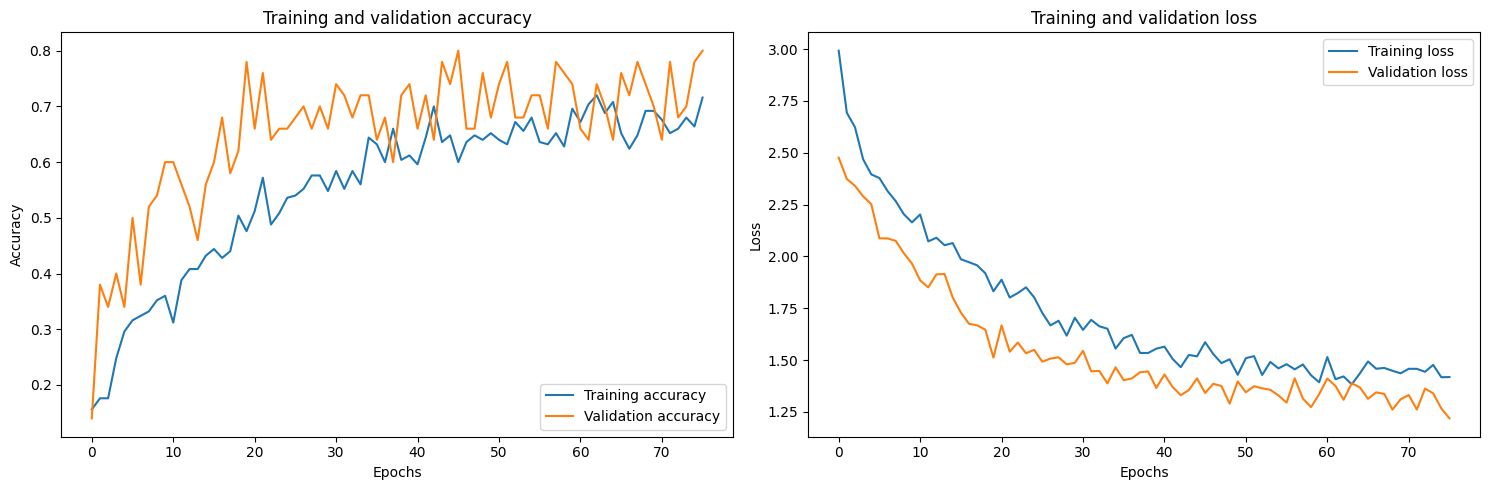

In [12]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']
# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
# Get number of epochs
epochs = range(len(acc))

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation accuracy on the first subplot
ax1.plot(epochs, acc, label='Training accuracy')
ax1.plot(epochs, val_acc, label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training and validation loss on the second subplot
ax2.plot(epochs, loss, label='Training loss')
ax2.plot(epochs, val_loss, label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()